<img src="https://www.segmentify.com/wp-content/uploads/2021/08/Top-Customer-Segmentation-Examples-every-Marketer-Needs-to-Know.png" alt="Description of the image" width="500" height="300">


<b><h1 style="text-align: center;color:red">Customer Segmentation</h1></b>


## 1. Data preparation

<h3>Importing Necessasry Libraries</h3>

In [1]:
import subprocess
import sys
import warnings

# Function to install packages
def install_and_import(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Packages to check/install
packages = [
    "pandas", "numpy", "matplotlib", "seaborn", "datetime", "nltk", 
    "pathlib", "sklearn", "wordcloud", "IPython", "plotly"
]

# Install and import all packages
for package in packages:
    install_and_import(package)

# Suppress all warnings
warnings.filterwarnings("ignore")

# Now import the packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import nltk
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Plotly notebook initialization
init_notebook_mode(connected=True)

# Matplotlib settings
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline


## 2. Exploratory Data Analysis

In [2]:
# importing dataset
df_initial = pd.read_csv('data.csv', encoding='latin1')

In [3]:
#displaying first ten rows of dataset
df_initial.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


<h3>2.1 Countries</h3>

In [4]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of total countries in the dataframe: {}'.format(len(countries)))

Number of total countries in the dataframe: 37


<h3>2.2 Customers and products</h3>

In [5]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4070,25900,4372


The dataset includes information about 4,372 users who purchased 3,684 distinct products. In total, approximately 22,000 transactions were recorded.

In [6]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


The initial lines of this list reveal several notable observations:

1. There are entries with the prefix **C** in the `InvoiceNo` variable, which signifies canceled transactions.  
2. Some users appear only once in the dataset and purchased just a single product (e.g., user **12346**).  
3. There are frequent users who consistently place orders with a high quantity of items.

<h3>2.2.1 Cancelling orders</h3>

To begin with, I determine the total number of transactions that correspond to canceled orders:

In [7]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


<b>The number of canceled orders is 3,654 out of 22,190, accounting for approximately 16.47% of all transactions. This indicates that the proportion of cancellations is relatively high (around 16% of the total transactions). Next, let’s examine the first few rows of the dataframe:</b>

In [8]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom
286628,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,8/2/2011 8:48,2.25,12347.0,Iceland
72263,542237,47559B,TEA TIME OVEN GLOVE,10,1/26/2011 14:30,1.25,12347.0,Iceland
72264,542237,21154,RED RETROSPOT OVEN GLOVE,10,1/26/2011 14:30,1.25,12347.0,Iceland


From these lines, it is evident that when an order is canceled, there is typically a corresponding transaction in the dataframe that is nearly identical, differing primarily in the `Quantity` and `InvoiceDate` fields. I choose to verify if this pattern holds true for all such entries. To accomplish this, I focus on identifying records with a negative quantity and checking whether there is a matching transaction with the same details (e.g., `CustomerID`, `Description`, and `UnitPrice`) but a positive quantity.

In [9]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID      14527.0
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


The initial hypothesis does not hold true due to the presence of 'Discount' entries. I re-evaluate the hypothesis, this time excluding the 'Discount' entries from the analysis.

In [10]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                             15311.0
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once again, the initial hypothesis is disproven, as cancellations do not always correspond to prior orders.  

At this stage, I choose to add a new variable to the dataframe to indicate whether a portion of an order has been canceled. For cancellations without matching counterparts, it is likely that some are due to purchases made before December 2010, which marks the starting point of the database. Below, I analyze the canceled orders and investigate the presence of corresponding transactions.

In [11]:
# df_cleaned = df_initial.copy(deep=True)
# df_cleaned["QuantityCanceled"] = 0

# entry_to_remove = []
# doubtfull_entry = []

# for index, col in df_initial.iterrows():
#     if (col["Quantity"] > 0) or col["Description"] == "Discount":
#         continue
#     df_test = df_initial[
#         (df_initial["CustomerID"] == col["CustomerID"])
#         & (df_initial["StockCode"] == col["StockCode"])
#         & (df_initial["InvoiceDate"] < col["InvoiceDate"])
#         & (df_initial["Quantity"] > 0)
#     ].copy()
#     # _________________________________
#     # Cancelation WITHOUT counterpart
#     if df_test.shape[0] == 0:
#         doubtfull_entry.append(index)
#     # ________________________________
#     # Cancelation WITH a counterpart
#     elif df_test.shape[0] == 1:
#         index_order = df_test.index[0]
#         df_cleaned.loc[index_order, "QuantityCanceled"] = -col["Quantity"]
#         entry_to_remove.append(index)
#     # ______________________________________________________________
#     # Various counterparts exist in orders: we delete the last one
#     elif df_test.shape[0] > 1:
#         df_test.sort_index(axis=0, ascending=False, inplace=True)
#         for ind, val in df_test.iterrows():
#             if val["Quantity"] < -col["Quantity"]:
#                 continue
#             df_cleaned.loc[ind, "QuantityCanceled"] = -col["Quantity"]
#             entry_to_remove.append(index)
#             break

In [12]:
# # Remove entries marked for removal
# df_cleaned.drop(entry_to_remove, inplace=True)

# # Save the cleaned DataFrame to a CSV file
# output_file = "cleaned_data.csv"
# df_cleaned.to_csv(output_file, index=False)


In the function above, I examined two scenarios:

1. A canceled order exists without a corresponding counterpart.  
2. There is at least one counterpart with the exact same quantity.  

The indices of the canceled orders corresponding to these scenarios are stored in two separate lists:
- **`doubtfull_entry`**: Contains the indices of canceled orders without a counterpart.
- **`entry_to_remove`**: Contains the indices of canceled orders with at least one counterpart.

The sizes of these lists are as follows:

In [13]:
# print("entry_to_remove: {}".format(len(entry_to_remove)))
# print("doubtfull_entry: {}".format(len(doubtfull_entry)))

In [14]:
df_cleaned= pd.read_csv("cleaned_data.csv")

The entries in the `doubtfull_entry` list represent cancellations without any corresponding prior orders. In practice, I choose to remove all these entries, which account for approximately 1.4% and 0.2% of the total entries in the dataframe, respectively.

Next, I proceed to verify the number of remaining entries that correspond to cancellations but were not removed by the previous filtering step.

In [15]:
# # Ensure indices to remove are valid
# valid_entry_to_remove = [idx for idx in entry_to_remove if idx in df_cleaned.index]
# valid_doubtfull_entry = [idx for idx in doubtfull_entry if idx in df_cleaned.index]

# # Drop the valid indices
# df_cleaned.drop(valid_entry_to_remove, axis=0, inplace=True)
# df_cleaned.drop(valid_doubtfull_entry, axis=0, inplace=True)

# # Check remaining entries with specific conditions
# remaining_entries = df_cleaned[(df_cleaned["Quantity"] < 0) & (df_cleaned["StockCode"] != "D")]

# print("Number of entries to be deleted: {}".format(remaining_entries.shape[0]))
# remaining_entries.head()


For instance, when examining the purchases of a customer from one of the aforementioned entries for the same product as the canceled transaction, the following observations can be made:

In [16]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
83600,543371,22464,HANGING METAL HEART LANTERN,3,2/7/2011 14:53,1.65,14048.0,United Kingdom,0
83612,543371,22464,HANGING METAL HEART LANTERN,1,2/7/2011 14:53,1.65,14048.0,United Kingdom,0
110949,C545852,22464,HANGING METAL HEART LANTERN,-5,3/7/2011 13:49,1.65,14048.0,United Kingdom,0


<h3>2.2.2 StockCode</h3>

As observed earlier, certain values in the **`StockCode`** variable signify specific types of transactions (e.g., `D` for Discount). To investigate further, I examine the contents of this variable by identifying all codes that consist solely of letters. Here's how this can be done:

In [17]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [18]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
DOT             -> DOTCOM POSTAGE                
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
S               -> SAMPLES                       
AMAZONFEE       -> AMAZON FEE                    
DCGS0076        -> SUNJAR LED NIGHT NIGHT LIGHT  
DCGS0003        -> BOXED GLASS ASHTRAY           
gift_0001_40    -> Dotcomgiftshop Gift Voucher £40.00
DCGS0070        -> CAMOUFLAGE DOG COLLAR         
m               -> Manual                        
gift_0001_50    -> Dotcomgiftshop Gift Voucher £50.00
gift_0001_30    -> Dotcomgiftshop Gift Voucher £30.00
gift_0001_20    -> Dotcomgiftshop Gift Voucher £20.00
DCGS0055        -> nan                           
DCGS0072        -> nan                           
DCGS0074        -> nan                           
DCGS0069        -> OOH LA LA DOGS 

<h3>2.2.3 Basket Price</h3>

In [19]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61209,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,74215,0.00
283222,562032,22423,REGENCY CAKESTAND 3 TIER,3,8/2/2011 8:48,12.75,12347.0,Iceland,0,38.25
283221,562032,21975,PACK OF 60 DINOSAUR CAKE CASES,24,8/2/2011 8:48,0.55,12347.0,Iceland,0,13.20
283220,562032,84991,60 TEATIME FAIRY CAKE CASES,24,8/2/2011 8:48,0.55,12347.0,Iceland,0,13.20
283219,562032,84992,72 SWEETHEART FAIRY CAKE CASES,24,8/2/2011 8:48,0.55,12347.0,Iceland,0,13.20


Each entry in the dataframe represents the price for a single product, meaning orders are distributed across multiple rows. To compute the total price of each order, I group all purchases belonging to the same order and aggregate their prices. Here's how it can be done:

In [20]:
# 1. Sum of purchases per user and order
temp = df_cleaned.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)[
    "TotalPrice"
].sum()
basket_price = temp.rename(columns={"TotalPrice": "Basket Price"})

# 2. Date of the order (Fix applied here)
# Convert 'InvoiceDate' to datetime format
df_cleaned["InvoiceDate"] = pd.to_datetime(df_cleaned["InvoiceDate"], errors="coerce")

# Handle invalid dates (drop rows with invalid or missing dates)
df_cleaned = df_cleaned.dropna(subset=["InvoiceDate"])

# Convert 'InvoiceDate' to an integer representation (Unix timestamp in seconds)
df_cleaned["InvoiceDate_int"] = df_cleaned["InvoiceDate"].astype("int64") // 10**9

# Group by 'CustomerID' and 'InvoiceNo' to calculate the mean InvoiceDate in seconds
temp = df_cleaned.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)[
    "InvoiceDate_int"
].mean()

# Remove the intermediate 'InvoiceDate_int' column
df_cleaned.drop("InvoiceDate_int", axis=1, inplace=True)

# Convert the mean InvoiceDate back to datetime format and add it to 'basket_price'
basket_price.loc[:, "InvoiceDate"] = pd.to_datetime(temp["InvoiceDate_int"], unit="s")

# 3. Select significant entries
basket_price = basket_price[basket_price["Basket Price"] > 0]
basket_price.sort_values("CustomerID")[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347.0,537626,711.79,2010-12-07 14:57:00
2,12347.0,542237,475.39,2011-01-26 14:30:00
3,12347.0,549222,636.25,2011-04-07 10:43:00
4,12347.0,556201,382.52,2011-06-09 13:01:00
5,12347.0,562032,584.91,2011-08-02 08:48:00
6,12347.0,573511,1294.32,2011-10-31 12:25:00


Text(0.5, 1.01, 'Breakdown of order amounts')

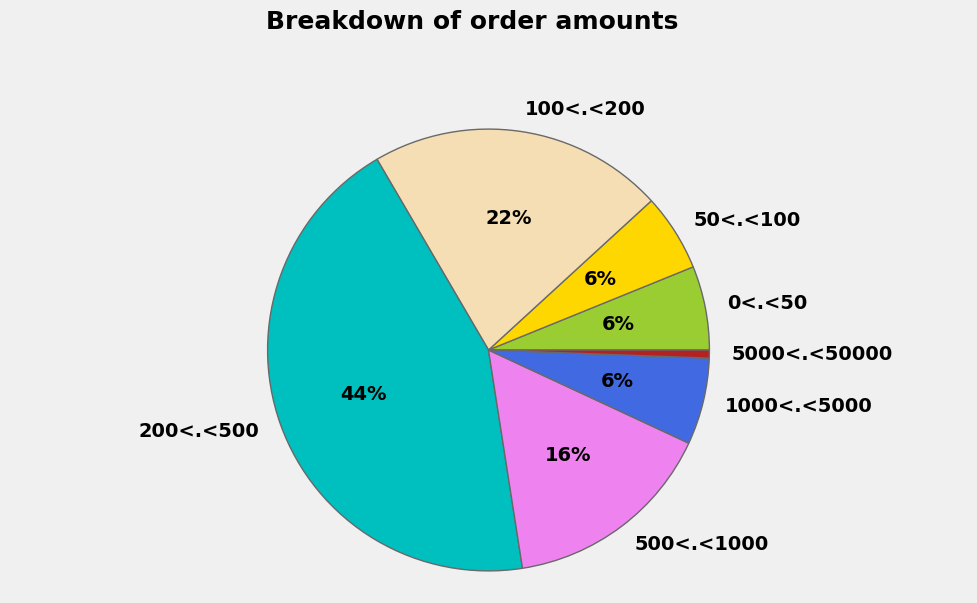

In [21]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Breakdown of order amounts", ha="center", fontsize=18)

It is evident that most orders involve relatively substantial purchases, as approximately 65% of them result in total amounts exceeding £200.

# 3. Insight on product categories

In the dataframe, each product is uniquely identified by the **`StockCode`** variable, while a brief description of the product is provided in the **`Description`** variable. In this section, I aim to utilize the information in the **`Description`** variable to classify and group the products into distinct categories.

<h3>3.1 Products Description</h3>

In [22]:
is_noun = lambda pos: pos[:2] == "NN"


def keywords_inventory(dataframe, colonne="Description"):
    # Ensure necessary NLTK resources are downloaded
    import nltk

    nltk.download("punkt")
    nltk.download("averaged_perceptron_tagger")

    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    count_keywords = dict()
    icount = 0

    for s in dataframe[colonne]:
        if pd.isnull(s):
            continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)  # Tokenize words
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print("Number of keywords in variable '{}': {}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

The described function processes the **`Description`** column of the dataframe to analyze and group product descriptions systematically. Here's an outline of the operations it performs:

1. **Extract Names from Descriptions**:
   - Identifies proper nouns and common words in the product descriptions to isolate meaningful terms.

2. **Group Names by Word Roots**:
   - For each extracted name, the function determines the root form of the word (e.g., stemming or lemmatization).
   - Aggregates all names sharing the same root into a set.

3. **Count Root Occurrences**:
   - Counts the frequency of each word root in the dataframe to identify commonly recurring terms.

4. **Select a Representative Keyword for Each Root**:
   - When multiple names are associated with the same root, the function selects the shortest word as the representative keyword.
   - This ensures that singular forms are chosen over plural variants where applicable.

In [23]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [ ]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

The function execution produces three outputs:

1. **`keywords`**: A list of the extracted keywords.  
2. **`keywords_roots`**: A dictionary where each key is a word root, and the value is a list of words associated with that root.  
3. **`count_keywords`**: A dictionary that records the frequency of each word.

Next, the `count_keywords` dictionary is converted into a list, allowing the keywords to be sorted based on their frequency of occurrence.

In [25]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

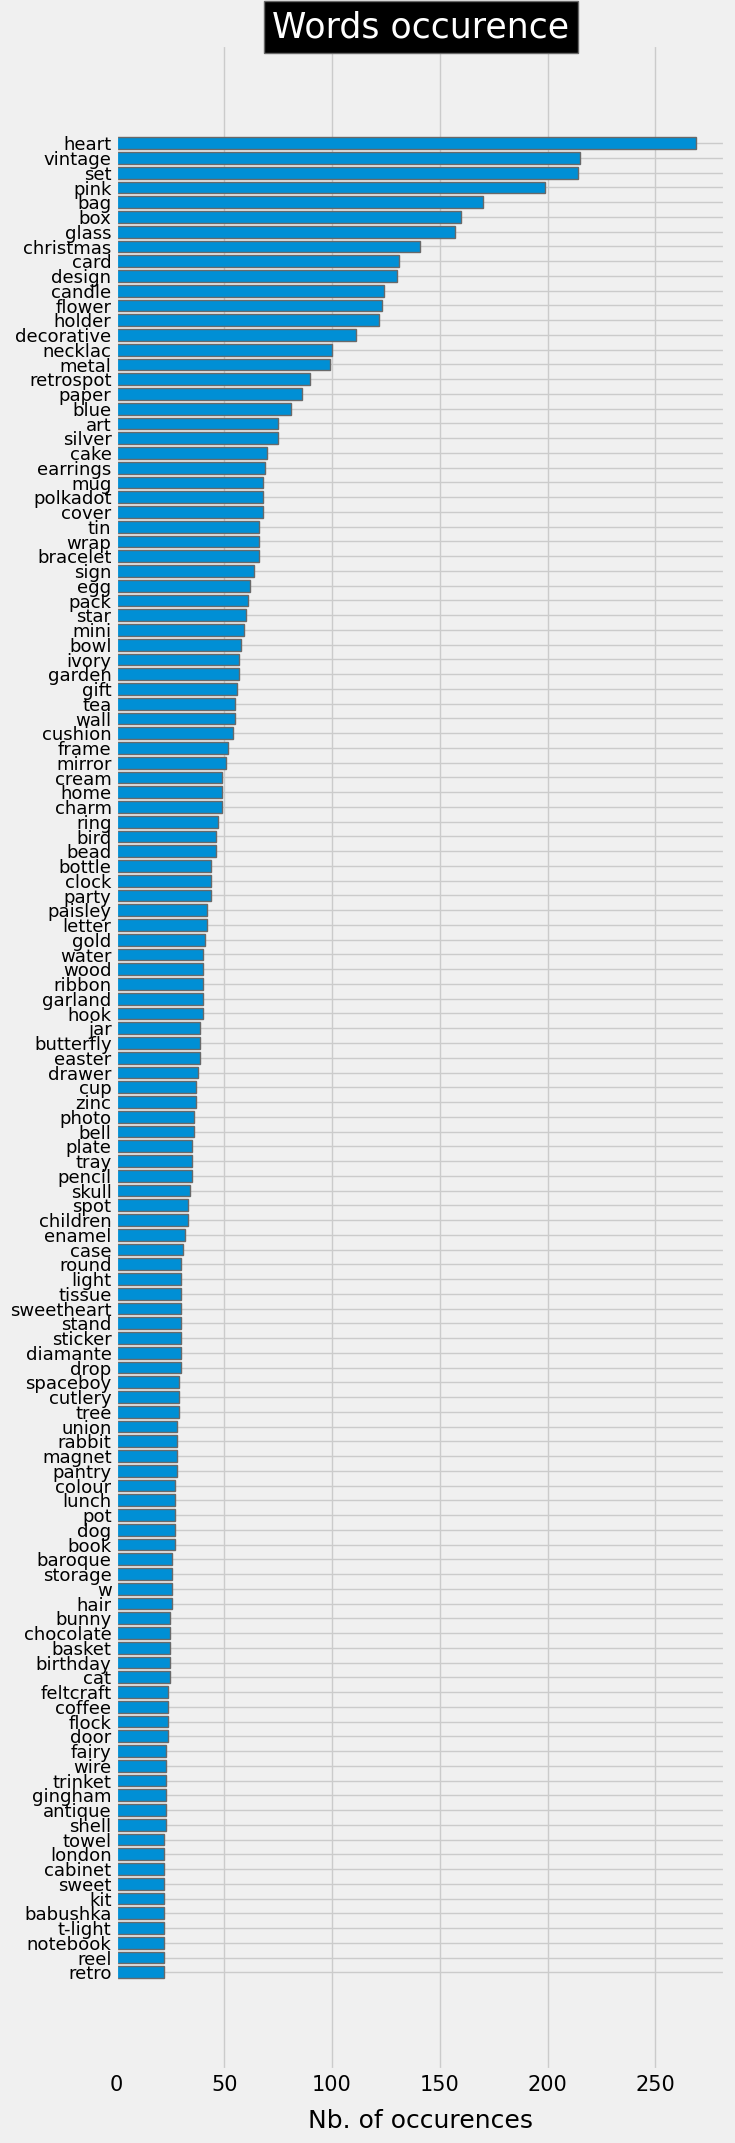

In [26]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

<h3>3.2 Defining product categories</h3>

The resulting list contains over 1,400 keywords, with the most frequent ones appearing in more than 200 product descriptions. However, upon reviewing the list, I notice that some keywords are irrelevant or uninformative, such as colors or other meaningless terms. Consequently, I exclude these words from the subsequent analysis and focus only on those keywords that appear more than 13 times.

In [27]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_products))

mots conservés: 197


____
#### 3.2.1 Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

   
|   | mot 1  |  ...  | mot j  | ...  | mot N  |
|:-:|---|---|---|---|---|
| produit 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|produit i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| produit M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the  𝑎𝑖,𝑗
  coefficient is 1 if the description of the product  𝑖
  contains the word  𝑗
 , and 0 otherwise.

In [28]:
# Ensure 'Description' column is free of NaN values
liste_produits = df_cleaned["Description"].dropna().unique()

X = pd.DataFrame()
for key, occurence in list_products:  # Assuming list_products is a valid list of tuples
    X.loc[:, key] = list(map(lambda x: int(key.upper() in x), liste_produits))

The **𝑋 matrix** represents the words found in the product descriptions using a one-hot encoding approach. To improve the balance of groups in terms of the number of elements, I discovered that incorporating the price range significantly helps. Therefore, I extend the matrix by adding six additional columns, each representing the price range of the products.

In [29]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = ".>{}".format(threshold[i])
    else:
        col = "{}<.<{}".format(threshold[i], threshold[i + 1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[df_cleaned["Description"] == prod]["UnitPrice"].mean()
    j = 0
    while prix > threshold[j]:  
        j += 1
        if j == len(threshold):
            break
    X.loc[i, label_col[j - 1]] = 1

In [30]:
print("{:<8} {:<20} \n".format("gamme", "nb. produits") + 20 * "-")
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = ".>{}".format(threshold[i])
    else:
        col = "{}<.<{}".format(threshold[i], threshold[i + 1])
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       729                 
1<.<2       998                 
2<.<3       739                 
3<.<5       741                 
5<.<10      597                 
.>10        419                 


____
#### 3.2.2 Creating clusters of products


In this section, I will classify the products into distinct groups. For matrices with binary encoding, the most appropriate metric for calculating distances is [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). While the **kmeans** method in sklearn employs Euclidean distance—which can be used—it is not the ideal choice for categorical variables. To utilize Hamming's metric, the [kmodes](https://pypi.python.org/pypi/kmodes/) package is required. However, this package is not available on the current platform. As a result, I will use the **kmeans** method, even though it is not the most optimal option.

To approximately determine the number of clusters that best represent the data, I use the silhouette score:  

---

In [31]:
matrix = X.to_numpy()
for n_clusters in range(3, 10):
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 3 The average silhouette_score is : 0.09310323551849482
For n_clusters = 4 The average silhouette_score is : 0.12053574670994238
For n_clusters = 5 The average silhouette_score is : 0.1316694665877751
For n_clusters = 6 The average silhouette_score is : 0.13329922374536873
For n_clusters = 7 The average silhouette_score is : 0.12247815190166908
For n_clusters = 8 The average silhouette_score is : 0.1230721243043613
For n_clusters = 9 The average silhouette_score is : 0.12199174929786599


In [32]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.140:
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 5 The average silhouette_score is : 0.13595510796384958
For n_clusters = 5 The average silhouette_score is : 0.13720414037373568
For n_clusters = 5 The average silhouette_score is : 0.13720414037373568
For n_clusters = 5 The average silhouette_score is : 0.1316694665877751
For n_clusters = 5 The average silhouette_score is : 0.13720414037373568
For n_clusters = 5 The average silhouette_score is : 0.13720414037373568
For n_clusters = 5 The average silhouette_score is : 0.1316694665877751
For n_clusters = 5 The average silhouette_score is : 0.13463969010619437
For n_clusters = 5 The average silhouette_score is : 0.13463969010619437
For n_clusters = 5 The average silhouette_score is : 0.1400109862239671


___
#### 3.2.3  Characterizing the content of clusters

In [33]:
pd.Series(clusters).value_counts()

1    1160
4     998
3     739
2     729
0     597
Name: count, dtype: int64

In [34]:
import matplotlib.cm as cm

def graph_component_silhouette(
    n_clusters, lim_x, mat_size, sample_silhouette_values, clusters
):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use("fivethirtyeight")
    mpl.rc("patch", edgecolor="dimgray", linewidth=1)
    # ____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.8,
        )
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(
            -0.03,
            y_lower + 0.5 * size_cluster_i,
            str(i),
            color="red",
            fontweight="bold",
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round, pad=0.3"),
        )
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

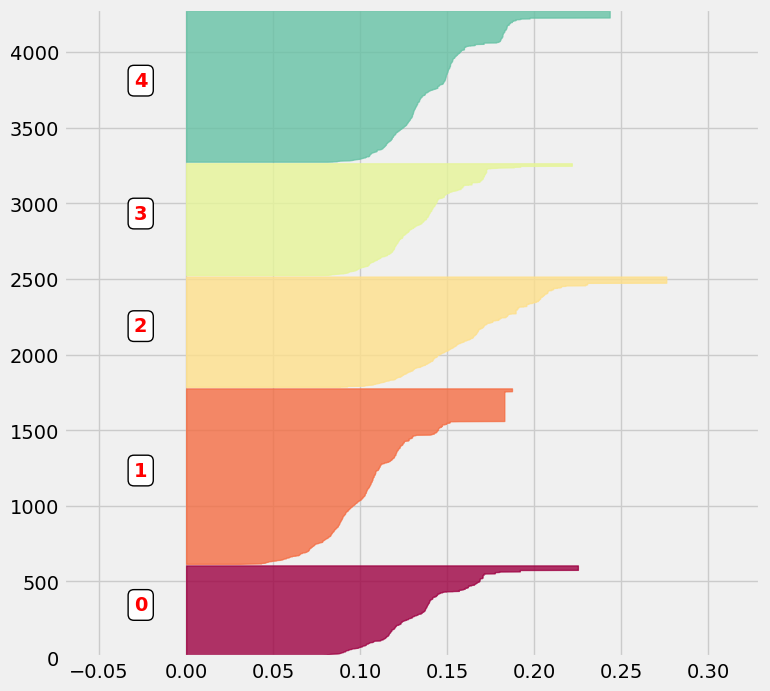

In [35]:
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(
    n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters
)

Let’s now examine the types of objects represented by each cluster. To gain an overall understanding of their contents, I identify the most frequently occurring keywords within each cluster.

In [36]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ["art", "set", "heart", "pink", "blue", "tag"]:
            continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

To evaluate the quality of the classification, we can visualize the silhouette scores for each element within the different clusters. The following figure, adapted from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html), illustrates this concept:

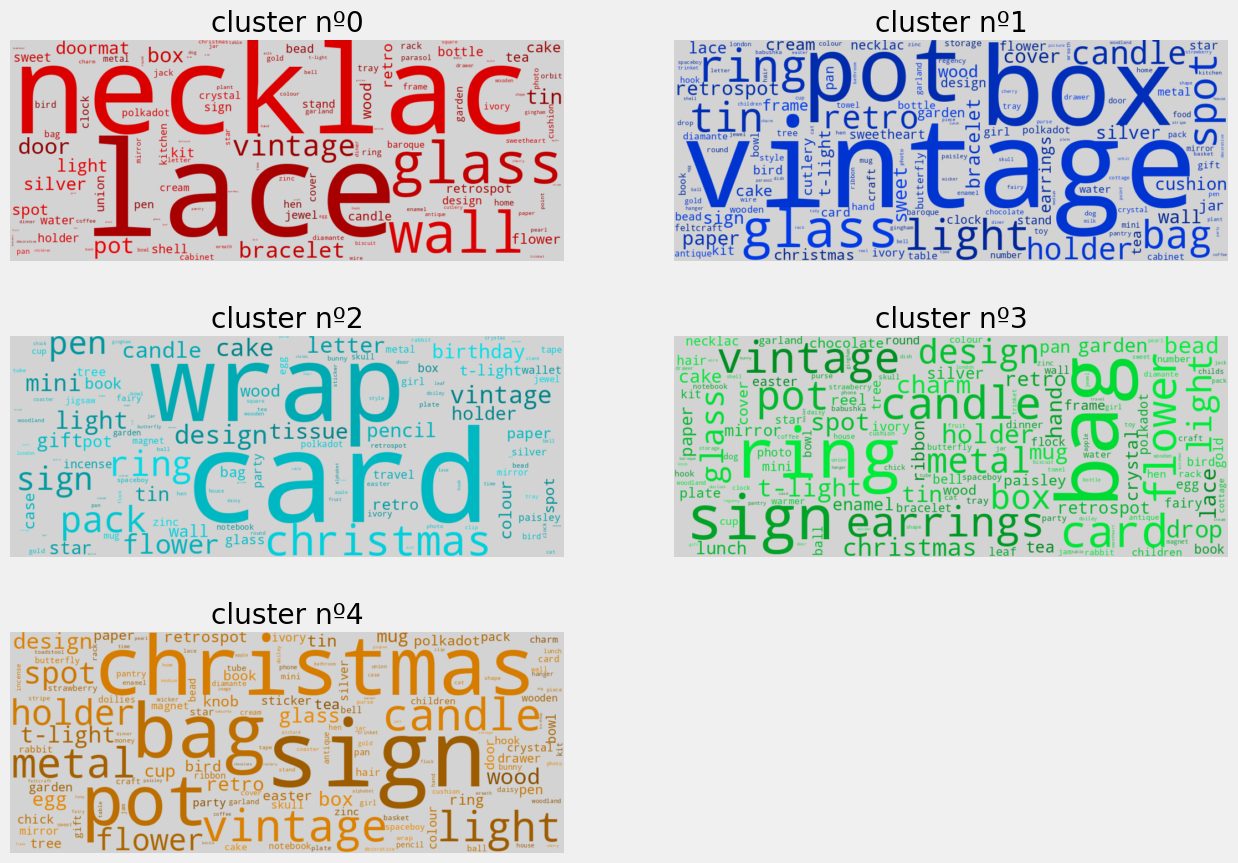

In [37]:
def random_color_func(
    word=None,
    font_size=None,
    position=None,
    orientation=None,
    font_path=None,
    random_state=None,
):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    wordcloud = WordCloud(
        width=1000,
        height=400,
        background_color="lightgrey",
        max_words=1628,
        relative_scaling=1,
        color_func=random_color_func,
        normalize_plurals=False,
    )
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis("off")
    plt.title("cluster nº{}".format(increment - 1))


fig = plt.figure(1, figsize=(14, 14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i]  # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key=lambda x: x[1], reverse=True)
    make_wordcloud(liste, i + 1)

From this analysis, we can observe that, for instance, one cluster includes objects that might be linked to gifts, with keywords like Christmas, packaging, and card. Another cluster appears to focus on luxury items and jewelry, featuring keywords such as necklace, bracelet, lace, and silver. However, it’s also evident that many words overlap across different clusters, making it challenging to clearly differentiate between them.

**Principal Component Analysis**

To verify whether these clusters are genuinely distinct, I examine their composition. Due to the high number of variables in the original matrix, I begin by conducting a Principal Component Analysis (PCA).

In [38]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

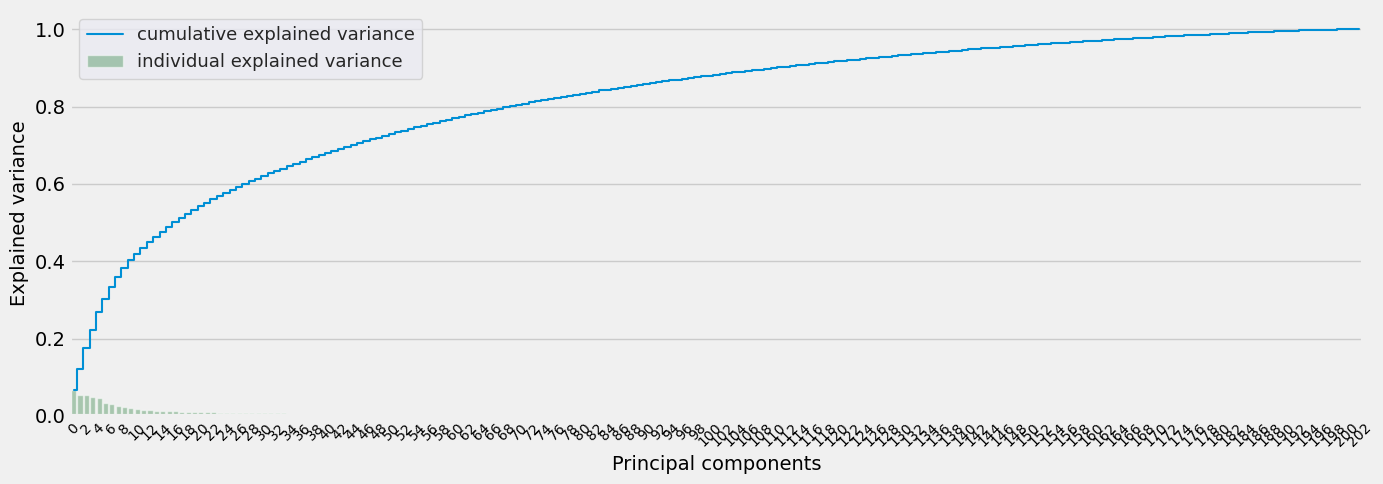

In [39]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

# Cumulative explained variance plot
plt.step(
    range(matrix.shape[1]),
    pca.explained_variance_ratio_.cumsum(),
    where="mid",
    label="cumulative explained variance",
)

# Individual explained variance plot
sns.barplot(
    x=np.arange(1, matrix.shape[1] + 1),  # Explicitly name the x argument
    y=pca.explained_variance_ratio_,  # Explicitly name the y argument
    alpha=0.5,
    color="g",
    label="individual explained variance",
    ax=ax,  # Use the ax for better subplot integration
)

# Set x-axis ticks at even intervals
ax.set_xticks(range(0, matrix.shape[1] + 1, 2))  # Adjust step size as needed
ax.set_xticklabels(
    range(0, matrix.shape[1] + 1, 2), rotation=45, fontsize=10
)  # Rotate for readability

# Add labels, legend, and formatting
plt.ylabel("Explained variance", fontsize=14)
plt.xlabel("Principal components", fontsize=14)
plt.legend(loc="upper left", fontsize=13)
plt.tight_layout()  # Adjust layout to prevent clipping

plt.show()

In [40]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat["cluster"] = pd.Series(clusters)

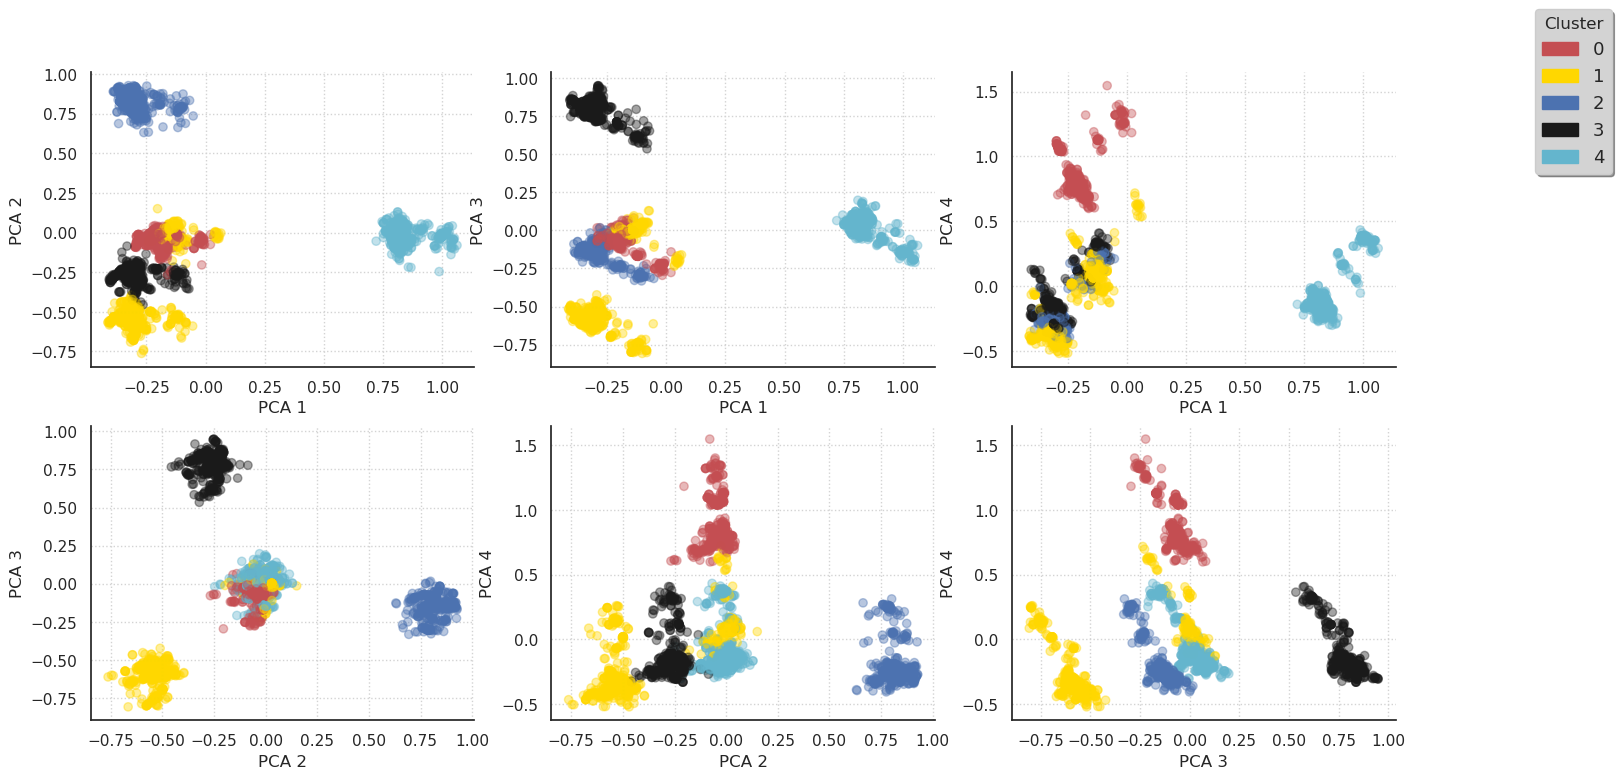

In [41]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0: "r", 1: "gold", 2: "b", 3: "k", 4: "c", 5: "g"}
label_color = [LABEL_COLOR_MAP[l] for l in mat["cluster"]]

fig = plt.figure(figsize=(15, 8))
increment = 0
for ix in range(4):
    for iy in range(ix + 1, 4):
        increment += 1
        ax = fig.add_subplot(2, 3, increment)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.4)
        plt.ylabel("PCA {}".format(iy + 1), fontsize=12)
        plt.xlabel("PCA {}".format(ix + 1), fontsize=12)
        ax.yaxis.grid(color="lightgray", linestyle=":")
        ax.xaxis.grid(color="lightgray", linestyle=":")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        if increment == 9:
            break
    if increment == 9:
        break

# _______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color=LABEL_COLOR_MAP[i], label=i))

plt.legend(
    handles=comp_handler,
    bbox_to_anchor=(1.1, 0.97),
    title="Cluster",
    facecolor="lightgrey",
    shadow=True,
    frameon=True,
    framealpha=1,
    fontsize=13,
    bbox_transform=plt.gcf().transFigure,
)

plt.show()


## 4. Customer categories

### 4.1 Formatting data

In the previous section, the various products were categorized into five clusters. As a preliminary step to proceed with the analysis, this clustering information needs to be incorporated into the dataframe. To achieve this, I create a categorical variable, `categ_product`, which assigns each product to its corresponding cluster.

In [42]:
corresp = dict()
for key, val in zip(liste_produits, clusters):
    corresp[key] = val
    
df_cleaned["categ_product"] = df_cleaned.loc[:, "Description"].map(corresp)

___
#### 4.1.1 Grouping products

In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

In [43]:
for i in range(5):
    col = "categ_{}".format(i)
    df_temp = df_cleaned[df_cleaned["categ_product"] == i]
    price_temp = df_temp["UnitPrice"] * (
        df_temp["Quantity"] - df_temp["QuantityCanceled"]
    )
    price_temp = price_temp.apply(lambda x: x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace=True)
    
df_cleaned[
    [
        "InvoiceNo",
        "Description",
        "categ_product",
        "categ_0",
        "categ_1",
        "categ_2",
        "categ_3",
        "categ_4",
    ]
][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1.0,0.00,15.30,0.0,0.0,0.0
1,536365,WHITE METAL LANTERN,1.0,0.00,20.34,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,1.0,0.00,22.00,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0.0,20.34,0.00,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0.0,20.34,0.00,0.0,0.0,0.0


In [44]:
# Sum of purchases / user & order
temp = df_cleaned.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)[
    "TotalPrice"
].sum()
basket_price = temp.rename(columns={"TotalPrice": "Basket Price"})

# Percentage of order price / product category
for i in range(5):
    col = "categ_{}".format(i)
    temp = df_cleaned.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)[col].sum()
    basket_price[col] = temp[col].values  # Assign only the column values

# Date of the order
df_cleaned["InvoiceDate_int"] = df_cleaned["InvoiceDate"].astype("int64")
temp = df_cleaned.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)[
    "InvoiceDate_int"
].mean()
df_cleaned.drop("InvoiceDate_int", axis=1, inplace=True)
basket_price["InvoiceDate"] = pd.to_datetime(temp["InvoiceDate_int"])

# Select significant entries
basket_price = basket_price[basket_price["Basket Price"] > 0]
result = basket_price.sort_values("CustomerID", ascending=True)[:5]

print(result)

   CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1     12347.0    537626        711.79   137.59   351.00    23.40    52.20   
2     12347.0    542237        475.39    34.00   226.55    57.84    80.40   
3     12347.0    549222        636.25    51.00   155.35    50.40    69.30   
4     12347.0    556201        382.52    51.00   190.76    21.00    84.36   
5     12347.0    562032        584.91    51.00   349.41    52.80    36.90   

   categ_4                   InvoiceDate  
1    147.6 2010-12-07 14:57:00.000000000  
2     76.6 2011-01-26 14:29:59.999999744  
3    310.2 2011-04-07 10:43:00.000000000  
4     35.4 2011-06-09 13:01:00.000000000  
5     94.8 2011-08-02 08:48:00.000000000  


#### 4.1.2 Separation of data over time

The `basket_price` dataframe includes data spanning a 12-month period. One of the goals is to build a model that can analyze and predict the behaviors of customers visiting the site, starting from their very first visit. To evaluate the model under realistic conditions, I divide the dataset by using the first 10 months for model development and reserving the last two months for testing.

In [45]:
print(basket_price["InvoiceDate"].min(), "->", basket_price["InvoiceDate"].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [46]:
import pandas as pd
import datetime

# Convert the cutoff date to Pandas Timestamp for compatibility
cutoff_date = pd.Timestamp("2011-10-01")

# Split into training and testing sets
set_entrainement = basket_price[basket_price["InvoiceDate"] < cutoff_date]
set_test = basket_price[basket_price["InvoiceDate"] >= cutoff_date]

# Create a copy of the training set
basket_price = set_entrainement.copy(deep=True)

# Print for verification
print("Training Set:\n", set_entrainement.head())
print("Test Set:\n", set_test.head())

Training Set:
    CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1     12347.0    537626        711.79   137.59   351.00    23.40    52.20   
2     12347.0    542237        475.39    34.00   226.55    57.84    80.40   
3     12347.0    549222        636.25    51.00   155.35    50.40    69.30   
4     12347.0    556201        382.52    51.00   190.76    21.00    84.36   
5     12347.0    562032        584.91    51.00   349.41    52.80    36.90   

   categ_4                   InvoiceDate  
1    147.6 2010-12-07 14:57:00.000000000  
2     76.6 2011-01-26 14:29:59.999999744  
3    310.2 2011-04-07 10:43:00.000000000  
4     35.4 2011-06-09 13:01:00.000000000  
5     94.8 2011-08-02 08:48:00.000000000  
Test Set:
     CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
6      12347.0    573511       1294.32    117.1   629.12    115.2   306.90   
7      12347.0    581180        224.82      0.0    30.00     16.8   138.84   
12     12349.0    5

In [47]:
# ________________________________________________________________
# nb de visites et stats sur le montant du panier / utilisateurs
transactions_per_user = basket_price.groupby(by=["CustomerID"])["Basket Price"].agg(
    ["count", "min", "max", "mean", "sum"]
)
for i in range(5):
    col = "categ_{}".format(i)
    transactions_per_user.loc[:, col] = (
        basket_price.groupby(by=["CustomerID"])[col].sum()
        / transactions_per_user["sum"]
        * 100
    )

transactions_per_user.reset_index(drop=False, inplace=True)
basket_price.groupby(by=["CustomerID"])["categ_0"].sum()
transactions_per_user.sort_values("CustomerID", ascending=True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,5,382.52,711.79,558.172000,2790.86,11.630465,45.615688,7.361172,11.579226,23.813448
1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,34.800027,3.872605,41.296655
2,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,11.961722,3.050239,41.357656,43.630383
3,12352.0,6,144.35,840.30,345.663333,2073.98,16.224843,69.219568,0.000000,8.288412,6.267177
4,12353.0,1,89.00,89.00,89.000000,89.00,22.359551,64.606742,0.000000,0.000000,13.033708


In [48]:
last_date = basket_price["InvoiceDate"].max().date()

first_registration = pd.DataFrame(
    basket_price.groupby(by=["CustomerID"])["InvoiceDate"].min()
)
last_purchase = pd.DataFrame(
    basket_price.groupby(by=["CustomerID"])["InvoiceDate"].max()
)

test = first_registration.applymap(lambda x: (last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x: (last_date - x.date()).days)

transactions_per_user.loc[:, "LastPurchase"] = test2.reset_index(drop=False)[
    "InvoiceDate"
]
transactions_per_user.loc[:, "FirstPurchase"] = test.reset_index(drop=False)[
    "InvoiceDate"
]

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,5,382.52,711.79,558.172000,2790.86,11.630465,45.615688,7.361172,11.579226,23.813448,59,297
1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,34.800027,3.872605,41.296655,5,288
2,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,11.961722,3.050239,41.357656,43.630383,240,240
3,12352.0,6,144.35,840.30,345.663333,2073.98,16.224843,69.219568,0.000000,8.288412,6.267177,2,226
4,12353.0,1,89.00,89.00,89.000000,89.00,22.359551,64.606742,0.000000,0.000000,13.033708,134,134


In [49]:
n1 = transactions_per_user[transactions_per_user["count"] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print(
    "nb. de clients avec achat unique: {:<2}/{:<5} ({:<2.2f}%)".format(
        n1, n2, n1 / n2 * 100
    )
)

nb. de clients avec achat unique: 1448/3612  (40.09%)


In [50]:
list_cols = [
    "count",
    "min",
    "max",
    "mean",
    "categ_0",
    "categ_1",
    "categ_2",
    "categ_3",
    "categ_4",
]
# _____________________________________________________________
selected_customers = transactions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].to_numpy()

In [51]:
scaler = StandardScaler()
scaler.fit(matrix)
print("variables mean values: \n" + 90 * "-" + "\n", scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62735327 261.76263344 559.86711877 379.36367993  20.46613446
  30.32676378   9.01649241  17.18239295  23.01962468]


In [52]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

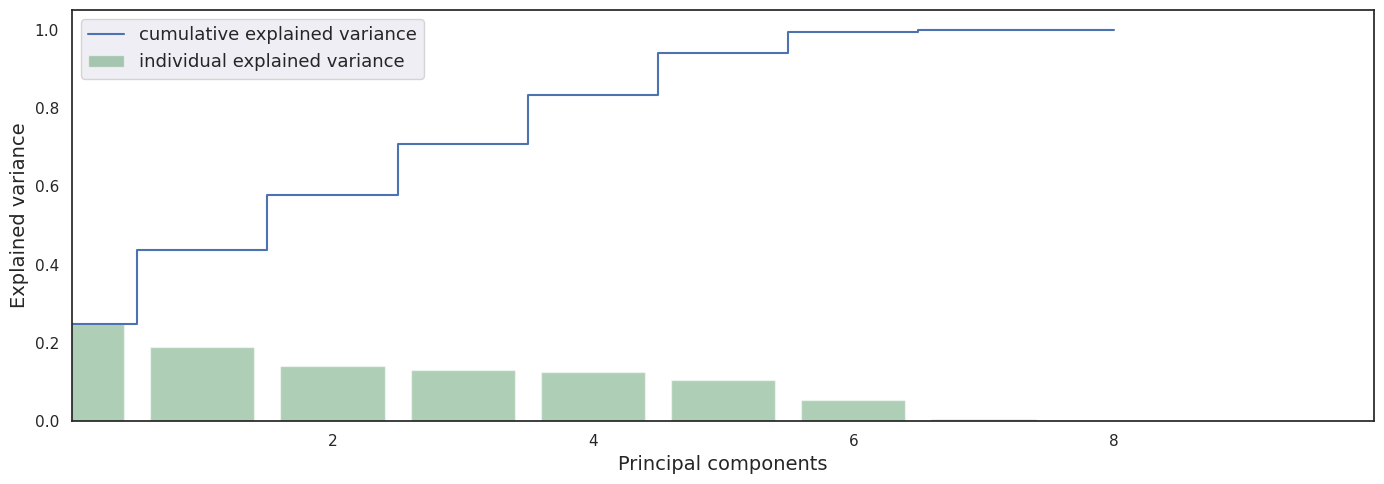

In [53]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

# Cumulative explained variance plot
plt.step(
    range(matrix.shape[1]),
    pca.explained_variance_ratio_.cumsum(),
    where="mid",
    label="cumulative explained variance",
)

# Individual explained variance plot
sns.barplot(
    x=np.arange(1, matrix.shape[1] + 1),  # Explicitly define x
    y=pca.explained_variance_ratio_,  # Explicitly define y
    alpha=0.5,
    color="g",
    label="individual explained variance",
    ax=ax,  # Use ax for better subplot integration
)

plt.xlim(0, 10)

# Adjust x-axis tick labels
ax.set_xticks(range(1, matrix.shape[1] + 1))
ax.set_xticklabels(
    [s if int(s) % 2 == 0 else "" for s in range(1, matrix.shape[1] + 1)]
)

# Add labels and legend
plt.ylabel("Explained variance", fontsize=14)
plt.xlabel("Principal components", fontsize=14)
plt.legend(loc="best", fontsize=13)
plt.tight_layout()

plt.show()

#### 4.2.2 Creation of customer categories

At this stage, I group clients into clusters using the standardized matrix created earlier and the `k-means` algorithm from `scikit-learn`. The optimal number of clusters is determined based on the silhouette score, which indicates that the best result is achieved with 11 clusters.

In [54]:
n_clusters = 11
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print("score de silhouette: {:<.3f}".format(silhouette_avg))

score de silhouette: 0.220


In [55]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns=["nb. de clients"]).T

""
nb. de clients


In [56]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat["cluster"] = pd.Series(clusters_clients)

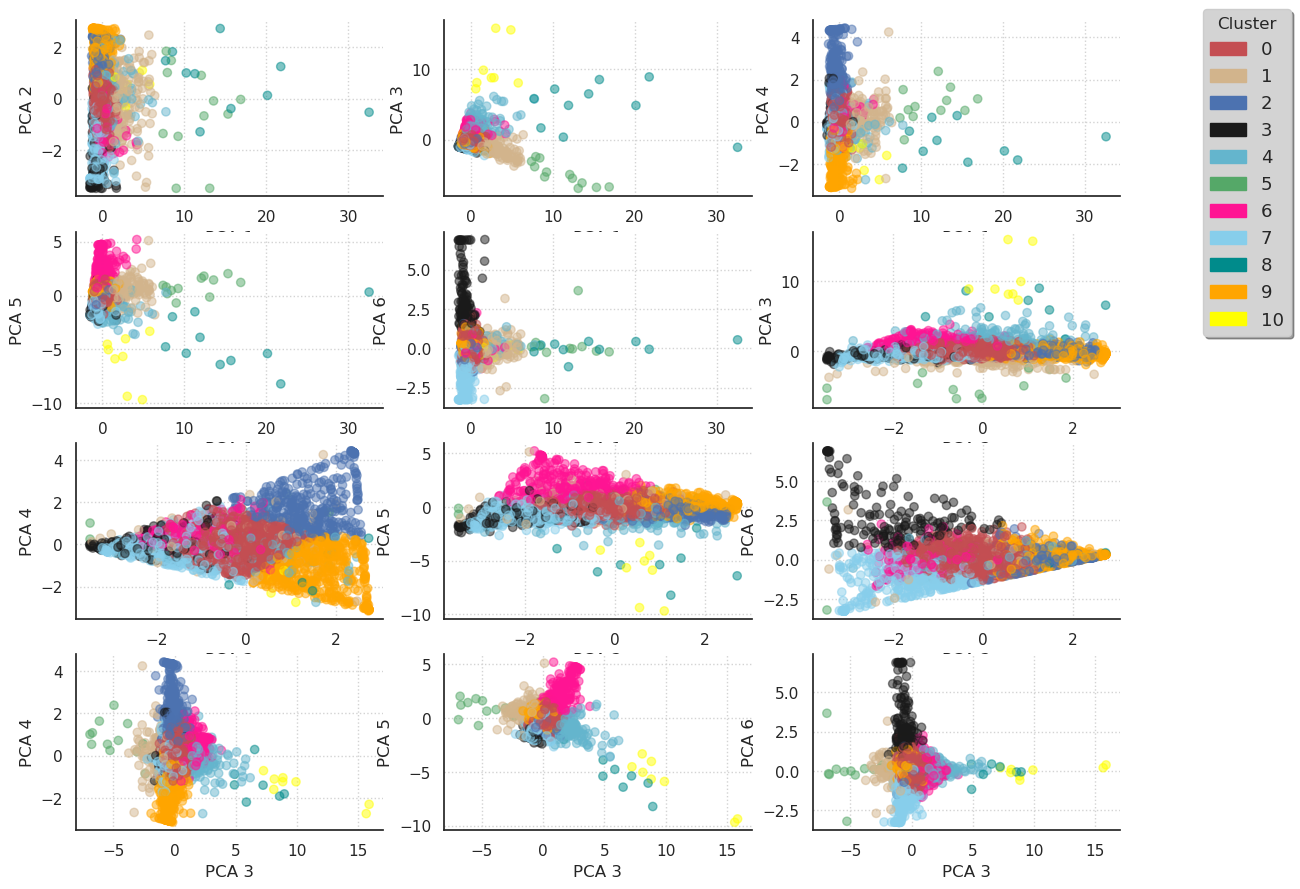

In [57]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {
    0: "r",
    1: "tan",
    2: "b",
    3: "k",
    4: "c",
    5: "g",
    6: "deeppink",
    7: "skyblue",
    8: "darkcyan",
    9: "orange",
    10: "yellow",
    11: "tomato",
    12: "seagreen",
}
label_color = [LABEL_COLOR_MAP[l] for l in mat["cluster"]]

fig = plt.figure(figsize=(12, 10))
increment = 0
for ix in range(6):
    for iy in range(ix + 1, 6):
        increment += 1
        ax = fig.add_subplot(4, 3, increment)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.5)
        plt.ylabel("PCA {}".format(iy + 1), fontsize=12)
        plt.xlabel("PCA {}".format(ix + 1), fontsize=12)
        ax.yaxis.grid(color="lightgray", linestyle=":")
        ax.xaxis.grid(color="lightgray", linestyle=":")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        if increment == 12:
            break
    if increment == 12:
        break


comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color=LABEL_COLOR_MAP[i], label=i))

plt.legend(
    handles=comp_handler,
    bbox_to_anchor=(1.1, 0.9),
    title="Cluster",
    facecolor="lightgrey",
    shadow=True,
    frameon=True,
    framealpha=1,
    fontsize=13,
    bbox_transform=plt.gcf().transFigure,
)

plt.tight_layout()

From this visualization, it becomes evident that the first principal component helps to distinguish the smallest clusters from the rest. More broadly, we observe that there is always a representation where two clusters appear distinct.

**Intra-Cluster Silhouette Score**

Similar to the analysis of product categories, another approach to evaluate the quality of cluster separation is by examining the silhouette scores within each cluster.

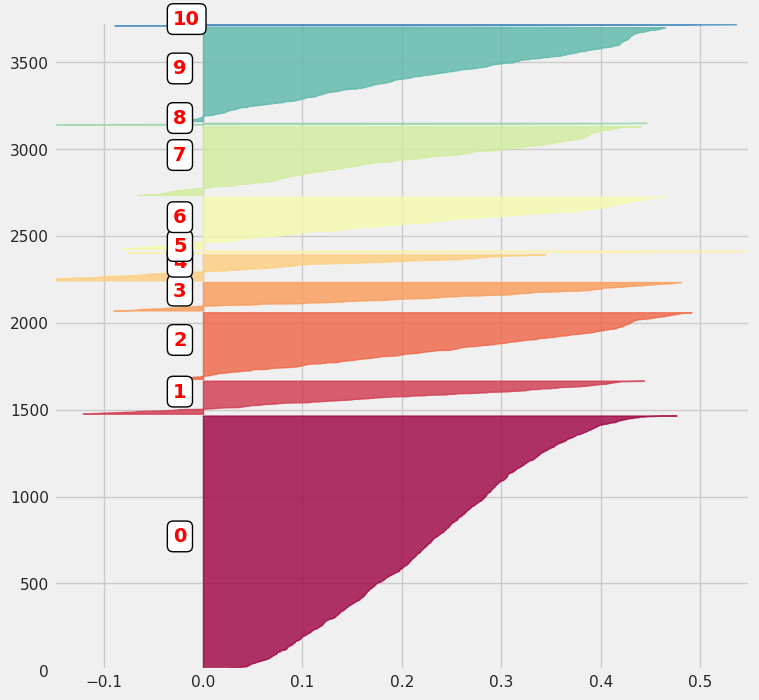

In [58]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
graph_component_silhouette(
    n_clusters,
    [-0.15, 0.55],
    len(scaled_matrix),
    sample_silhouette_values,
    clusters_clients,
)

At this point, I have confirmed that the clusters are generally distinct from one another. The next step is to analyze the behavior of customers within each cluster. To facilitate this, I add a variable to the `selected_customers` dataframe that specifies the cluster assignment for each customer.

In [59]:
selected_customers.loc[:, "cluster"] = clusters_clients

Next, I calculate the averages for the contents of this dataframe by grouping customers according to their clusters. This allows me to access insights such as the average basket price, the number of visits, and the total amount spent by customers in each cluster. Additionally, I compute the size of each group by determining the number of customers within each cluster (variable **size**).

In [60]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers["cluster"] == i].mean())
    test = test.T.set_index("cluster", drop=True)
    test["size"] = selected_customers[selected_customers["cluster"] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
# _____________________________________________________
merged_df.drop("CustomerID", axis=1, inplace=True)
print("number of customers:", merged_df["size"].sum())

merged_df = merged_df.sort_values("sum")

number of customers: 3612


Finally, I restructure the dataframe by arranging the clusters in order. First, I sort them based on the amount spent in each product category, and then by the total amount spent across all categories.

In [61]:
liste_index = []
for i in range(5):
    column = "categ_{}".format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
# ___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [s for s in merged_df.index if s not in liste_index]
# ___________________________________________________________
merged_df = merged_df.reindex(index=liste_index_reordered)
merged_df = merged_df.reset_index(drop=False)
display(
    merged_df[
        [
            "cluster",
            "count",
            "min",
            "max",
            "mean",
            "sum",
            "categ_0",
            "categ_1",
            "categ_2",
            "categ_3",
            "categ_4",
            "size",
        ]
    ]
)

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,2.0,2.473958,204.851276,331.784870,262.896695,682.730859,57.932948,21.090789,2.886904,7.377119,10.717778,384
1,9.0,2.380776,201.177471,343.144031,265.031918,673.372721,15.753162,64.134098,3.184734,7.749296,9.198591,541
2,3.0,2.109756,187.040305,313.407012,242.941224,554.217622,7.946351,12.393334,48.884388,9.152965,21.625327,164
3,6.0,3.263333,215.055267,424.478367,315.183974,1120.787233,8.945078,13.909988,5.543498,56.099825,15.501611,300
4,7.0,2.348485,199.974343,298.455482,245.947343,574.864371,8.350872,15.786710,8.891514,9.546070,57.424834,396
5,0.0,3.182567,223.453981,459.290151,332.245680,1070.777014,19.505317,29.407500,9.382882,17.713385,24.001573,1457
6,1.0,1.696335,1039.159686,1371.518120,1191.330888,2091.554403,19.029494,31.426115,8.116680,18.183911,23.244152,191
7,5.0,1.750000,3483.820833,3976.375000,3688.745056,6130.464167,23.629563,27.539303,10.581232,11.552412,26.697491,12
8,4.0,18.073826,90.239396,1595.331208,582.829180,9827.377987,21.009239,30.179707,7.426883,20.984557,20.433085,149
9,10.0,87.500000,21.917500,2657.693750,462.863301,38140.198750,19.969230,31.137178,6.735344,20.637641,21.520828,8


In [62]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]


class RadarChart:
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels=6):
        angles = np.arange(0, 360, 360.0 / len(variables))

        ix, iy = location[:]
        size_x, size_y = sizes[:]

        axes = [
            fig.add_axes([ix, iy, size_x, size_y], polar=True, label="axes{}".format(i))
            for i in range(len(variables))
        ]

        _, text = axes[0].set_thetagrids(angles, labels=variables)

        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid(False)

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            grid_label = [
                "{:.0f}".format(x) for x in grid
            ]  # Match the number of grid lines
            ax.set_rgrids(grid, labels=grid_label, angle=angles[i])
            ax.set_ylim(*ranges[i])

        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(
            0.5, 1.1, title, transform=self.ax.transAxes, ha="center", *args, **kw
        )

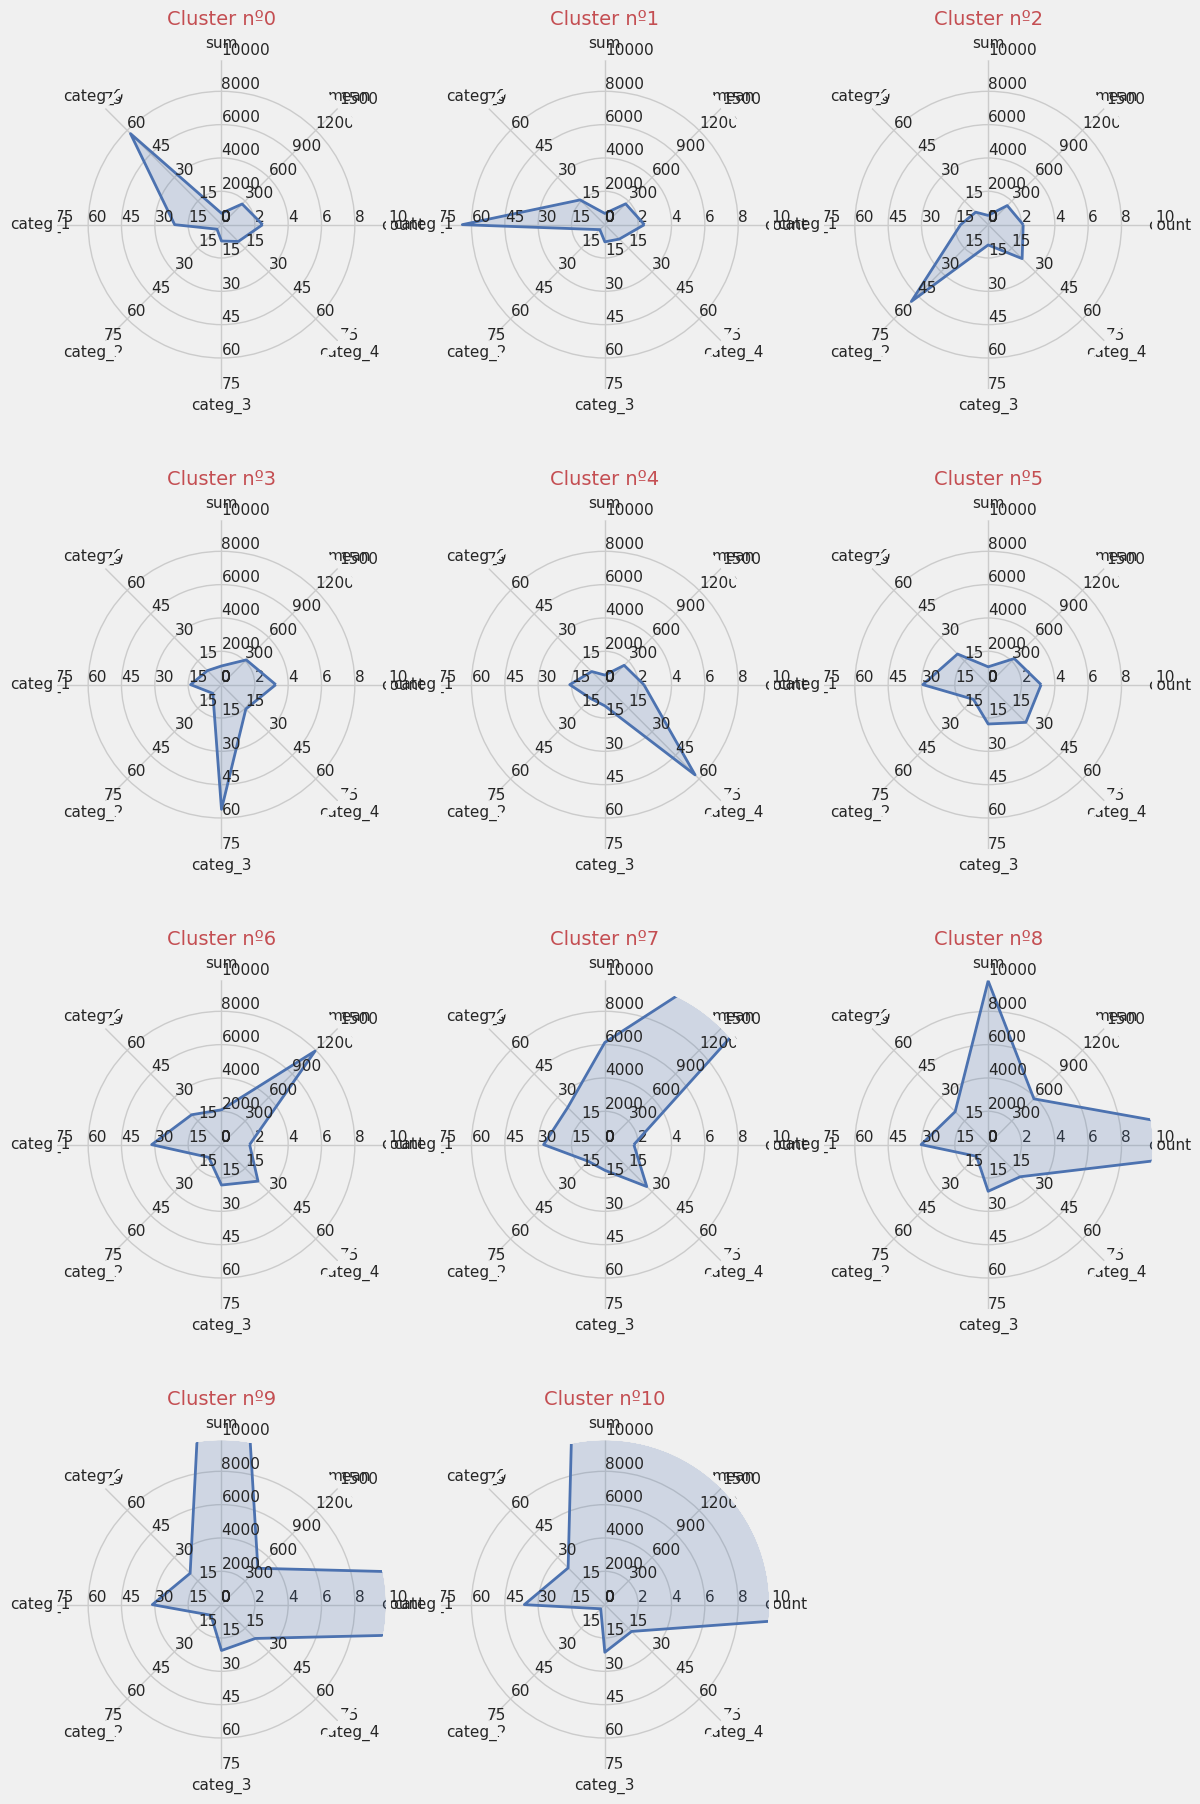

In [63]:
fig = plt.figure(figsize=(10, 12))

attributes = [
    "count",
    "mean",
    "sum",
    "categ_0",
    "categ_1",
    "categ_2",
    "categ_3",
    "categ_4",
]
ranges = [
    [0.01, 10],
    [0.01, 1500],
    [0.01, 10000],
    [0.01, 75],
    [0.01, 75],
    [0.01, 75],
    [0.01, 75],
    [0.01, 75],
]
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters
i_cols = 3
i_rows = n_groups // i_cols
size_x, size_y = (1 / i_cols), (1 / i_rows)

for ind in range(n_clusters):
    ix = ind % 3
    iy = i_rows - ind // 3
    pos_x = ix * (size_x + 0.05)
    pos_y = iy * (size_y + 0.05)
    location = [pos_x, pos_y]
    sizes = [size_x, size_y]

    # Data for the radar chart
    data = np.array(merged_df.loc[index[ind], attributes])
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color="b", linewidth=2.0)
    radar.fill(data, alpha=0.2, color="b")
    radar.title(title="Cluster nº{}".format(index[ind]), color="r")


For instance, it is noticeable that the first five clusters show a significant dominance in purchases within a specific product category. Other clusters, however, are differentiated by factors such as the average basket size (**mean**), the total amount spent by clients (**sum**), or the total number of visits they made (**count**).

## 5. Classification of customers

In this section, the goal is to develop a classifier capable of categorizing consumers into the client groups defined earlier. The aim is to enable this classification based on their first visit. To achieve this, I will evaluate several classifiers available in `scikit-learn`. To streamline their implementation, I first create a class that provides an interface for managing common functionalities shared across these classifiers.

In [64]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator=self.clf, param_grid=parameters, cv=Kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print(
            "Precision: {:.2f} % ".format(
                100 * metrics.accuracy_score(Y, self.predictions)
            )
        )

In [65]:
columns = ["mean", "categ_0", "categ_1", "categ_2", "categ_3", "categ_4"]
X = selected_customers[columns]
Y = selected_customers["cluster"]

Since the objective is to determine the class a client belongs to based solely on their first visit, I retain only the variables that describe the contents of the basket. Variables related to visit frequency or changes in basket price over time are excluded from the analysis.

In [66]:
#split the dataset in train and test sets:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, train_size=0.8
)

### 5.1 Support Vector Machine Classifier (SVC)

The first classifier I implement is the Support Vector Machine Classifier (SVC). To use this model, I create an instance of the `Class_Fit` class and call the `grid_search()` method. While invoking this method, I specify the following parameters:

- The hyperparameters to optimize
- The number of folds to use for cross-validation

In [67]:
from sklearn import svm
from sklearn.metrics import precision_score

# Create an empty list to store models and their precision scores
models_and_metrics = []

# Initialize Linear Support Vector Classifier
svc = Class_Fit(clf=svm.LinearSVC)

# Perform grid search with specified parameters
svc.grid_search(parameters=[{"C": np.logspace(-2, 2, 10)}], Kfold=5)

# Fit the grid search
svc.grid_fit(X=X_train, Y=Y_train)

# Get predictions using the best estimator from grid search
y_pred_svc = svc.grid.best_estimator_.predict(X_test)

# Compute precision manually (assuming `Y_test` is available)
precision_svc = precision_score(Y_test, y_pred_svc, average="weighted")

# Append model name and precision to the results list
models_and_metrics.append({"Model Name": "Linear SVC", "Precision": precision_svc})

# Print the precision and updated metrics list
print(f"Precision for Linear SVC: {precision_svc * 100:.2f} %")

Precision for Linear SVC: 79.22 %


In [68]:
svc.grid_fit(X=X_train, Y=Y_train)

In [69]:
svc.grid_predict(X_test, Y_test)

Precision: 84.37 % 


#### 5.1.1 Confusion Matrix

The accuracy of the results appears satisfactory. However, it's important to recall that when the classes were defined, there was a size imbalance among them. Notably, one class comprises approximately 40% of the clients. Therefore, it is crucial to examine how the predictions compare to the actual values across the different classes. This is done using confusion matrices. To represent these matrices, I utilize the code provided in the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [70]:
import itertools

def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    # _________________________________________________
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    # _________________________________________________
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    # _________________________________________________
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Confusion matrix, without normalization


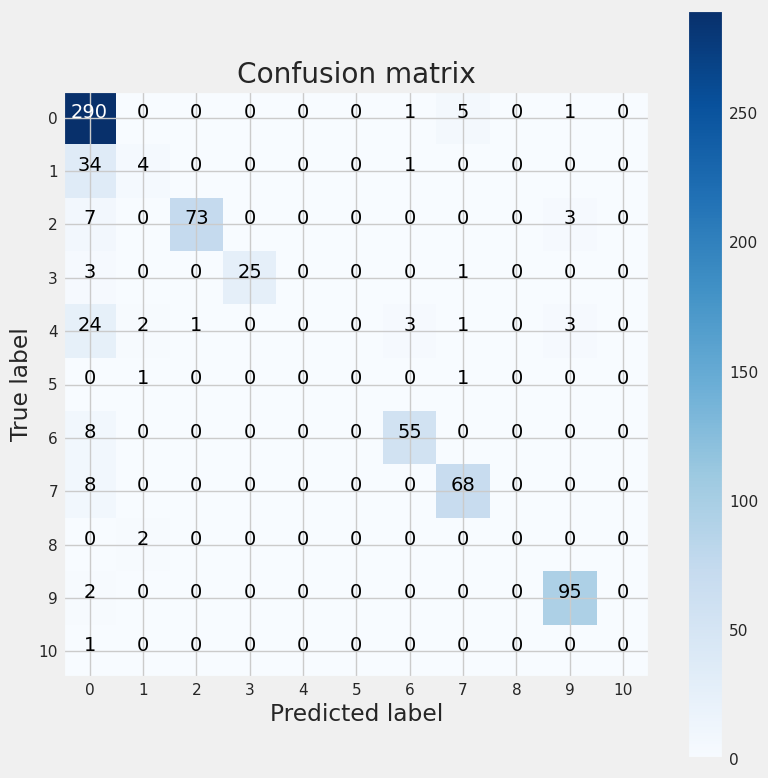

In [71]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix, classes=class_names, normalize=False, title="Confusion matrix"
)

#### 5.1.2 Learning Curve

A common method to evaluate the quality of a model fit is by plotting a learning curve. These curves are particularly useful for identifying potential issues such as overfitting or underfitting. Additionally, they can indicate how much the model might improve with a larger dataset. To generate this curve, I once again use the code from the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-examples-model-selection-plot-learning-curve-py).

In [72]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")
    return plt

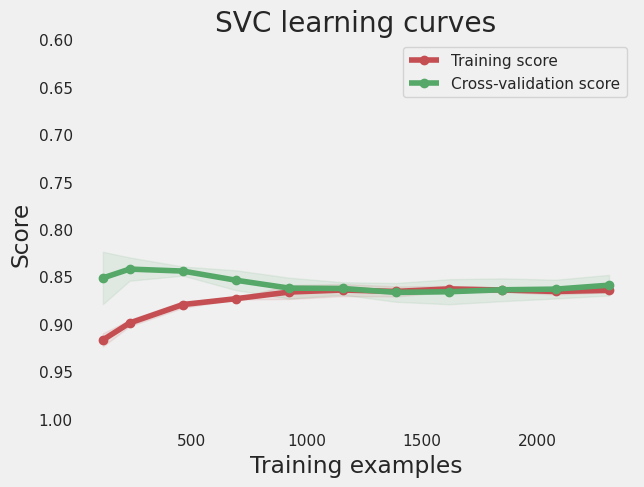

In [73]:
g = plot_learning_curve(
    svc.grid.best_estimator_,
    "SVC learning curves",
    X_train,
    Y_train,
    ylim=[1.01, 0.6],
    cv=5,
    train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
)

On the learning curve, it is evident that the training and cross-validation curves converge toward the same value as the sample size increases. This behavior is characteristic of a model with low variance, indicating that it does not suffer from overfitting. Furthermore, the training curve demonstrates a satisfactory level of accuracy, suggesting low bias. Therefore, the model is not underfitting the data.

___
### 5.2 Logistic Regression

Next, I evaluate the logistic regression classifier. Similar to the previous approach, I create an instance of the `Class_Fit` class, fit the model on the training data, and analyze how the predictions compare to the actual values.

In [74]:
lr = Class_Fit(clf=linear_model.LogisticRegression)
lr.grid_search(parameters=[{"C": np.logspace(-2, 2, 20)}], Kfold=5)
lr.grid_fit(X=X_train, Y=Y_train)

# Get predictions using the best estimator from grid search
y_pred_lr = lr.grid.best_estimator_.predict(X_test)

# Compute precision manually (assuming `Y_test` is available)
precision_lr = precision_score(Y_test, y_pred_lr, average="weighted")

# Append the model name and precision to the list
models_and_metrics.append({"Model Name": "Logistic Regression", "Precision": precision_lr})

# Print the precision and updated metrics list
print(f"Precision for Logistic Regression: {precision_lr * 100:.2f} %")


Precision for Logistic Regression: 84.45 %


Precision for Logistic Regression: 87.19 %


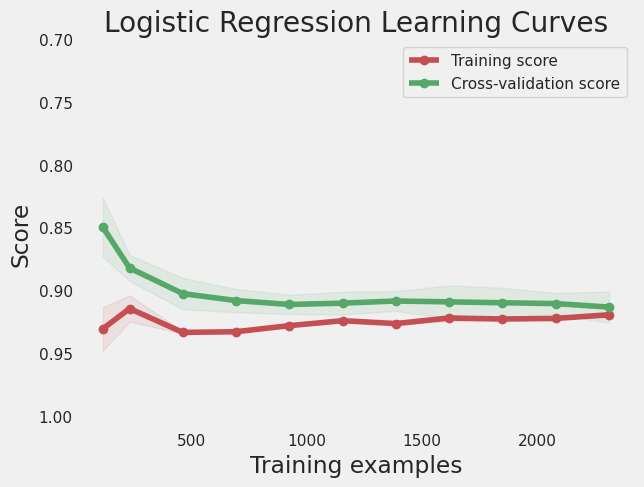

In [75]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Pass the LogisticRegression class to Class_Fit
lr = Class_Fit(clf=linear_model.LogisticRegression)

# Perform grid search with specified parameters
lr.grid_search(
    parameters=[{"C": np.logspace(-2, 2, 20), "max_iter": [500], "solver": ["lbfgs"]}],
    Kfold=5,
)

# Fit the grid search
lr.grid_fit(X=X_train_scaled, Y=Y_train)

# Get predictions using the best estimator from grid search
y_pred_lr = lr.grid.best_estimator_.predict(X_test_scaled)

# Compute precision manually (assuming `Y_test` is available)
precision_lr = precision_score(Y_test, y_pred_lr, average="weighted")

# Append model name and precision to the results list
models_and_metrics.append({"Model Name": "Logistic Regression", "Precision": precision_lr})

# Print the precision and updated metrics list
print(f"Precision for Logistic Regression: {precision_lr * 100:.2f} %")


# Plot the learning curve
g = plot_learning_curve(
    lr.grid.best_estimator_,
    "Logistic Regression Learning Curves",
    X_train_scaled,
    Y_train,
    ylim=[1.01, 0.7],
    cv=5,
    train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
)

### 5.3 k-Nearest Neighbors

In [76]:
# Initialize KNN Classifier
knn = Class_Fit(clf=neighbors.KNeighborsClassifier)

# Perform grid search with specified parameters
knn.grid_search(parameters=[{"n_neighbors": np.arange(1, 50, 1)}], Kfold=5)

# Fit the grid search
knn.grid_fit(X=X_train, Y=Y_train)

# Get predictions using the best estimator from grid search
y_pred_knn = knn.grid.best_estimator_.predict(X_test)

# Compute precision manually (assuming `Y_test` is available)
precision_knn = precision_score(Y_test, y_pred_knn, average="weighted")

# Append model name and precision to the results list
models_and_metrics.append({"Model Name": "K-Nearest Neighbors", "Precision": precision_knn})

# Print the precision and updated metrics list
print(f"Precision for K-Nearest Neighbors: {precision_knn * 100:.2f} %")

Precision for K-Nearest Neighbors: 78.66 %


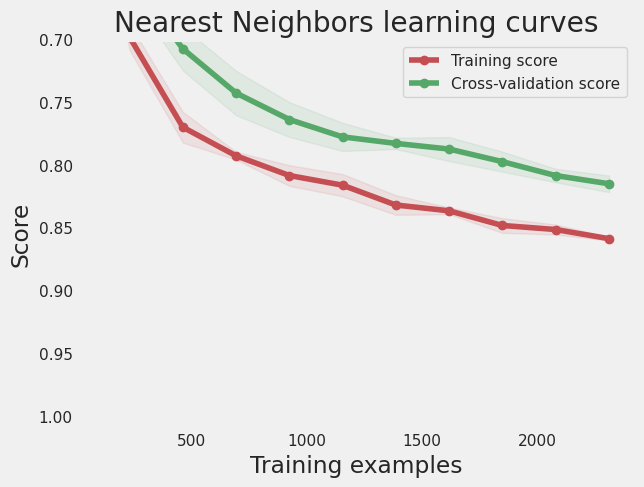

In [77]:
g = plot_learning_curve(
    knn.grid.best_estimator_,
    "Nearest Neighbors learning curves",
    X_train,
    Y_train,
    ylim=[1.01, 0.7],
    cv=5,
    train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
)

### 5.4 Decision Tree


In [78]:
# Initialize Decision Tree Classifier
tr = Class_Fit(clf=tree.DecisionTreeClassifier)

# Perform grid search with specified parameters
tr.grid_search(
    parameters=[{"criterion": ["entropy", "gini"], "max_features": ["sqrt", "log2"]}],
    Kfold=5,
)

# Fit the grid search
tr.grid_fit(X=X_train, Y=Y_train)

# Get predictions using the best estimator from grid search
y_pred_tr = tr.grid.best_estimator_.predict(X_test)

# Compute precision manually (assuming `Y_test` is available)
precision_tr = precision_score(Y_test, y_pred_tr, average="weighted")

# Append model name and precision to the results list
models_and_metrics.append({"Model Name": "Decision Tree", "Precision": precision_tr})

# Print the precision and updated metrics list
print(f"Precision for Decision Tree: {precision_tr * 100:.2f} %")

Precision for Decision Tree: 84.11 %


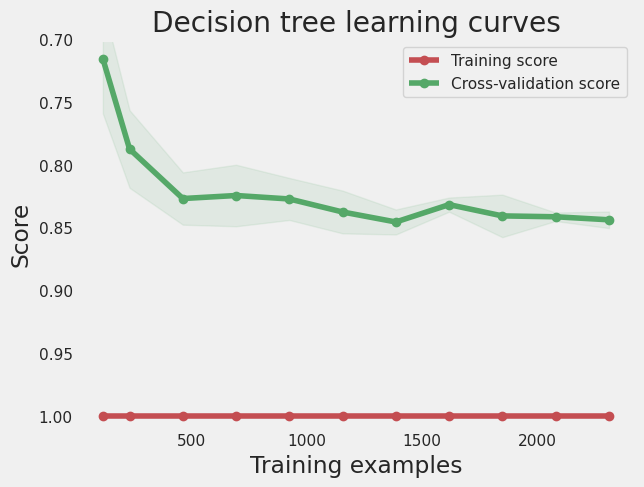

In [79]:
g = plot_learning_curve(
    tr.grid.best_estimator_,
    "Decision tree learning curves",
    X_train,
    Y_train,
    ylim=[1.01, 0.7],
    cv=5,
    train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
)

### 5.5 Random Forest

In [80]:
# Initialize Random Forest Classifier
rf = Class_Fit(clf=ensemble.RandomForestClassifier)

# Define the parameter grid for grid search
param_grid = {
    "criterion": ["entropy", "gini"],
    "n_estimators": [20, 40, 60, 80, 100],
    "max_features": ["sqrt", "log2"],
}

# Perform grid search with specified parameters
rf.grid_search(parameters=param_grid, Kfold=5)

# Fit the grid search
rf.grid_fit(X=X_train, Y=Y_train)

# Get predictions using the best estimator from grid search
y_pred_rf = rf.grid.best_estimator_.predict(X_test)

# Compute precision manually (assuming `Y_test` is available)
precision_rf = precision_score(Y_test, y_pred_rf, average="weighted")

# Append model name and precision to the results list
models_and_metrics.append({"Model Name": "Random Forest", "Precision": precision_rf})

# Print the precision and updated metrics list
print(f"Precision for Random Forest: {precision_rf * 100:.2f} %")

Precision for Random Forest: 85.77 %


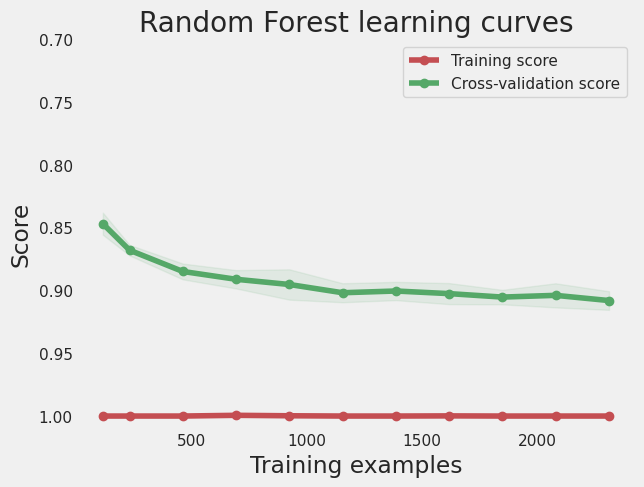

In [81]:
g = plot_learning_curve(
    rf.grid.best_estimator_,
    "Random Forest learning curves",
    X_train,
    Y_train,
    ylim=[1.01, 0.7],
    cv=5,
    train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
)

### 5.6 AdaBoost Classifier

In [82]:
# Initialize AdaBoost Classifier
ada = Class_Fit(clf=AdaBoostClassifier)

# Define the parameter grid for grid search
param_grid = {"n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

# Perform grid search with specified parameters
ada.grid_search(parameters=param_grid, Kfold=5)

# Fit the grid search
ada.grid_fit(X=X_train, Y=Y_train)

# Get predictions using the best estimator from grid search
y_pred_ada = ada.grid.best_estimator_.predict(X_test)

# Compute precision manually (assuming `Y_test` is available)
precision_ada = precision_score(Y_test, y_pred_ada, average="weighted")

# Append model name and precision to the results list
models_and_metrics.append({"Model Name": "AdaBoost", "Precision": precision_ada})

# Print the precision and updated metrics list
print(f"Precision for AdaBoost: {precision_ada * 100:.2f} %")
print(models_and_metrics)

Precision for AdaBoost: 31.01 %
[{'Model Name': 'Linear SVC', 'Precision': 0.7922080047415659}, {'Model Name': 'Logistic Regression', 'Precision': 0.8445301052243053}, {'Model Name': 'Logistic Regression', 'Precision': 0.8719443130111146}, {'Model Name': 'K-Nearest Neighbors', 'Precision': 0.7865620119420175}, {'Model Name': 'Decision Tree', 'Precision': 0.8410643153627897}, {'Model Name': 'Random Forest', 'Precision': 0.8577403505477535}, {'Model Name': 'AdaBoost', 'Precision': 0.31009262752001343}]


In [ ]:
g = plot_learning_curve(
    ada.grid.best_estimator_,
    "AdaBoost learning curves",
    X_train,
    Y_train,
    ylim=[1.01, 0.4],
    cv=5,
    train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
)

### 5.7 Gradient Boosting Classifier

In [84]:
gb = Class_Fit(clf=ensemble.GradientBoostingClassifier)
param_grid = {"n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters=param_grid, Kfold=5)
gb.grid_fit(X=X_train, Y=Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 88.80 % 


In [85]:
from sklearn.metrics import precision_score

# Get predictions using the best estimator from grid search
y_pred_gb = gb.grid.best_estimator_.predict(X_test)

# Compute precision manually (assuming `Y_test` is available)
precision_gb = precision_score(Y_test, y_pred_gb, average="weighted")

# Append model name and precision to the results list
models_and_metrics.append({"Model Name": "Gradient Boosting", "Precision": precision_gb})

# Print the precision and updated metrics list
print(f"Precision: {precision_gb * 100:.2f} %")


Precision: 85.31 %


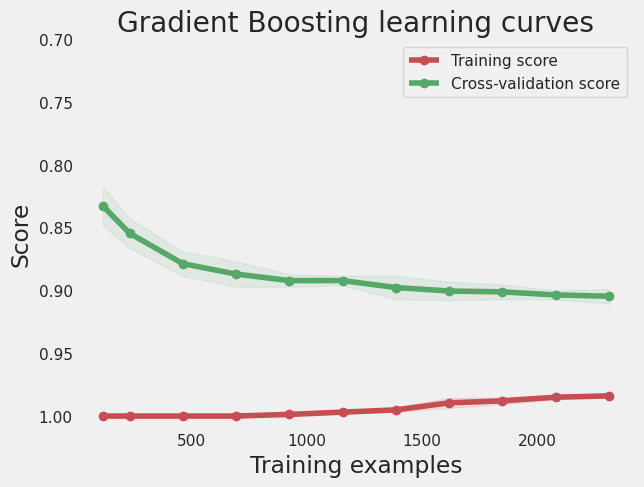

In [86]:
g = plot_learning_curve(
    gb.grid.best_estimator_,
    "Gradient Boosting learning curves",
    X_train,
    Y_train,
    ylim=[1.01, 0.7],
    cv=5,
    train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
)


### 5.8 Voting Ensemble Classifier

This accurately reflects the use of a voting mechanism to combine predictions from multiple models (`Random Forest`, `Gradient Boosting`, and `K-Nearest Neighbors`) in a unified approach. If you'd like to elaborate further, you can mention that you're using **soft voting**, which averages the predicted probabilities to make the final decision.

In [87]:
rf_best = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best = linear_model.LogisticRegression(**lr.grid.best_params_)

In [88]:
votingC = ensemble.VotingClassifier(
    estimators=[("rf", rf_best), ("gb", gb_best), ("knn", knn_best)], voting="soft"
)

In [89]:
VotingClassifier = votingC.fit(X_train, Y_train)

In [90]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100 * metrics.accuracy_score(Y_test, predictions)))

Precision: 89.49 % 


In [91]:
from sklearn.metrics import accuracy_score
# Compute precision manually (assuming `Y_test` is available)
precision_voting = precision_score(Y_test, predictions, average="weighted")

# Append model name and precision to the results list
models_and_metrics.append({"Model Name": "Voting Classifier", "Precision": precision_voting})

# Print the precision and accuracy of the Voting Classifier
print(f"Precision for Voting Ensemble Classifier: {precision_voting * 100:.2f} %")
print(f"Accuracy for Voting Ensemble Classifier: {accuracy_score(Y_test, predictions) * 100:.2f} %")

Precision for Voting Ensemble Classifier: 85.79 %
Accuracy for Voting Ensemble Classifier: 89.49 %




### 6. Model Performance Analysis

#### 6.1 Data Preparation
Detail the steps of converting the list of dictionaries into a DataFrame, grouping the data, and calculating the average precision scores.

#### 6.2 Calculating Average Precision
Explain how the mean precision scores are calculated for each model and sorted for visualization.

#### 6.3 Visualization of Precision Scores
Describe the process of creating a bar plot to display the average precision scores of the models.

#### 6.4 Insights from the Precision Plot
Discuss key observations from the bar plot, highlighting the performance comparison among the models.

In [92]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(models_and_metrics)

# Group by 'Model Name' and calculate the mean precision
average_precision = df.groupby('Model Name')['Precision'].mean().reset_index()

# Sort by Precision for better visualization
average_precision = average_precision.sort_values(by='Precision', ascending=False)

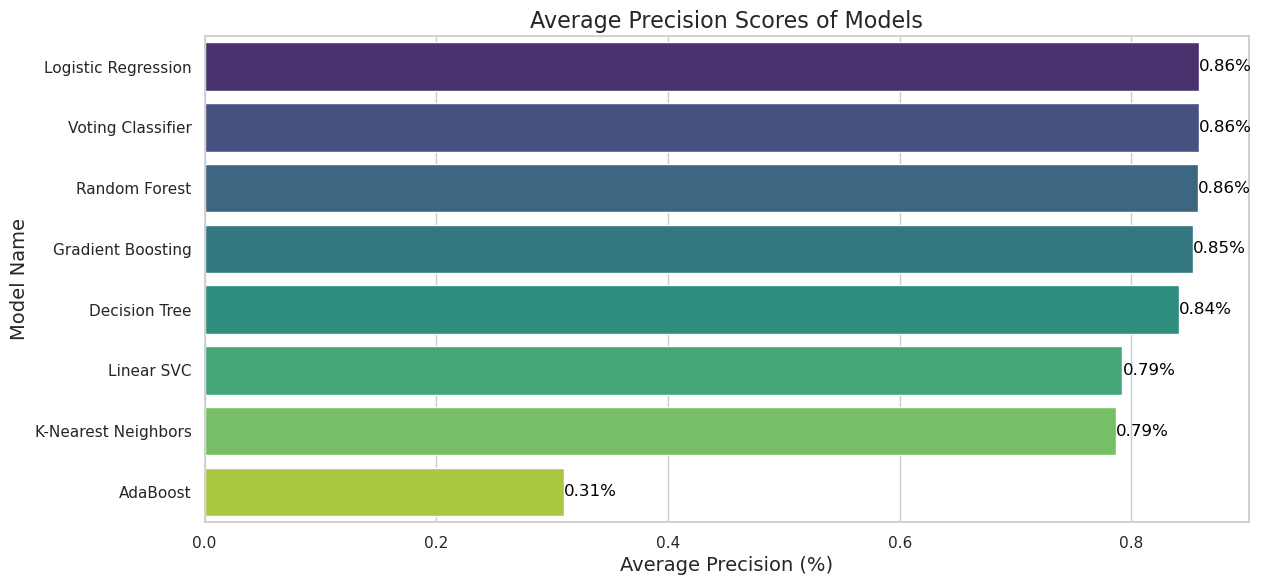

In [93]:
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Precision', y='Model Name', data=average_precision, palette='viridis')

# Add titles and labels
plt.title('Average Precision Scores of Models', fontsize=16)
plt.xlabel('Average Precision (%)', fontsize=14)
plt.ylabel('Model Name', fontsize=14)

# Add precision values on top of bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_width():.2f}%', 
                      (p.get_width(), p.get_y() + p.get_height() / 2), 
                      ha='left', va='center', 
                      color='black', fontsize=12)

# Show the plot
plt.show()